# Anomaly Detection

When to use anomaly detection vs. when to use supervised learning:

- **Anomaly detection:**
    - Very few positive examples (y = 1) (0-20 is common), with a large number of negative examples (y = 0).
    - If there are many different "types" of anomalies. It's challenging for any algorithm to learn from positive examples what the anomalies look like; future anomalies may bear no resemblance to any of the anomalous examples encountered thus far.
    - Examples: 
        - Fraud detection.
        - Manufacturing: finding new previously unseen defects in manufacturing.
        - Monitoring machines in a data center (different types of attacks or malfunctions).

- **Supervised learning:**
    - Large number of positive and negative examples.
    - Sufficient positive examples for the algorithm to grasp what positive examples entail; future positive examples are likely to resemble those in the training set.
    - Examples: 
        - Email spam classification.
        - Manufacturing: finding known previously seen defects.
        - Weather prediction (sunny/rainy/etc.).
        - Diseases classification.


## Librarys

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset

In [30]:
df = pd.read_csv("data\climate change\GlobalLandTemperaturesByCountry.csv")
print(df.columns)
df.head()

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [48]:
x = df[['dt', 'AverageTemperature', 'Country']]

x_brazil = x['Country'] == 'Brazil'
x = x[x_brazil]
x.dropna(inplace=True)
x['dt'] = pd.to_datetime(x['dt'])
x['Month'] = x['dt'].dt.month

sample_rows = x.sample(n=10)
sample_rows

,dt,AverageTemperature,Country,Month
77763,1886-06-01,22.171,Brazil,6
77380,1854-07-01,23.648,Brazil,7
78128,1916-11-01,25.173,Brazil,11
77990,1905-05-01,24.675,Brazil,5
78008,1906-11-01,25.530,Brazil,11
79283,2013-02-01,26.217,Brazil,2
77883,1896-06-01,22.819,Brazil,6
78383,1938-02-01,25.890,Brazil,2
77578,1871-01-01,24.768,Brazil,1
78783,1971-06-01,23.102,Brazil,6


In [45]:
x = x[['AverageTemperature', 'Month']]
x.head()

,AverageTemperature,Month
77110,24.935,1
77111,24.505,2
77112,24.617,3
77113,23.990,4
77114,23.124,5


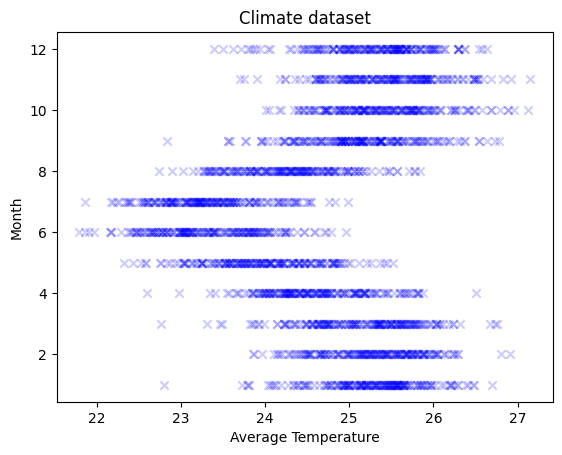

In [58]:
plt.scatter(x['AverageTemperature'], x['Month'], marker='x', c='b', alpha=0.2) 
plt.title("Climate dataset")
plt.ylabel('Month')
plt.xlabel('Average Temperature')
plt.show()

### Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

To estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th feature by using the following equations. To estimate the mean, you will use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$


In [3]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    mu = np.sum(X, axis=0) / m
    var = np.sum((X - mu) ** 2, axis=0) / m
    
    return mu, var

In [4]:
def multivariate_gaussian(X, mu, var):
    
    
    
    return 0

To implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
      
    $$
    \begin{aligned}
    prec&=&\frac{tp}{tp+fp}\\
    rec&=&\frac{tp}{tp+fn},
    \end{aligned}
    $$ 
    
    where:
      * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
      * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
      * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [ ]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = (p_val < epsilon)
        
        tp = sum((predictions == 1) & (y_val == 1))
        fp = sum((predictions == 1) & (y_val == 0))
        tn = sum((predictions == 0) & (y_val == 0))
        fn = sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)        
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1